# DATA 410 Lecture 7 - Spring 2022

<font face="Chalkboard" color="darkgreen" size=5> Validated Comparisons with Different Methods</font>

In [1]:
# general imports
# some libraries
import numpy as np
import pandas as pd
from scipy.linalg import lstsq
from scipy.sparse.linalg import lsmr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata, LinearNDInterpolator, NearestNDInterpolator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
# Tricubic Kernel
def Tricubic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,70/81*(1-d**3)**3)

# Quartic Kernel
def Quartic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,15/16*(1-d**2)**2)

# Epanechnikov Kernel
def Epanechnikov(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,3/4*(1-d**2)) 

In [3]:
#Defining the kernel local regression model

def lw_reg(X, y, xnew, kern, tau, intercept):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    n = len(X)
    yest = np.zeros(n)

    if len(y.shape)==1:
      y = y.reshape(-1,1)

    if len(X.shape)==1:
      X = X.reshape(-1,1)
    
    if intercept:
      X1 = np.column_stack([np.ones((len(X),1)),X])
    else:
      X1 = X

    w = np.array([kern((X - X[i])/(2*tau)) for i in range(n)]) 

    #Looping through all X-points
    for i in range(n):          
        W = np.diag(w[:,i])
        b = np.transpose(X1).dot(W).dot(y)
        A = np.transpose(X1).dot(W).dot(X1)
        #A = A + 0.001*np.eye(X1.shape[1]) # if we want L2 regularization
        #theta = linalg.solve(A, b) # A*theta = b
        theta, res, rnk, s = lstsq(A, b)
        yest[i] = np.dot(X1[i],theta)
    if X.shape[1]==1:
      f = interp1d(X.flatten(),yest,fill_value='extrapolate')
    else:
      f = LinearNDInterpolator(X, yest)
    output = f(xnew)
    if sum(np.isnan(output))>0:
      g = NearestNDInterpolator(X,y.ravel()) 
      output[np.isnan(output)] = g(xnew[np.isnan(output)]) #g(X[np.isnan(output)])
    return output

### Convex Hulls

Let $\vec{x_1}$, $\vec{x_2}$, ... $\vec{x_k}$ points in $\mathbb{R}^n.$

The convex hull of the points of $\vec{x_1}, \vec{x_2}, ... \vec{x_k}$ then are:


In [4]:
# imports for creating a Neural Network
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [5]:
cars = pd.read_csv("Data/cars.csv")
df = pd.read_csv('Data/Boston_Housing_Prices.csv')

X = cars[["CYL","ENG","WGT"]].values
y = cars['MPG'].values

#Needs scaling!

In [6]:
kf = KFold(n_splits=10,shuffle=True,random_state=1234)
#rfr = RandomForestRegressor(n_estimaors=100, max_depth=3)
scale = StandardScaler()
mse_lw = []
mse_rfr = []

for idx_train, idx_test in kf.split(X):
    xtrain = scale.fit_transform(X[idx_train])
    xtest = scale.fit_transform(X[idx_test])

    ytrain = y[idx_train]
    ytest = y[idx_test]
    rfr = RandomForestRegressor(n_estimators=100, max_depth=3)
    rfr.fit(xtrain, ytrain)
    yhat_rfr = rfr.predict(xtest)
    yhat_lw = lw_reg(xtrain,ytrain,xtest,Tricubic,1,intercept=True)

    mse_rfr.append(mse(ytest,yhat_rfr))
    mse_lw.append(mse(ytest, yhat_lw))
print("The Cross-validates MSE for multi dimensional Loess was: " + str(np.mean(mse_lw)))
print("The Cross-validates MSE for Random Forest was: " + str(np.mean(mse_rfr)))

The Cross-validates MSE for multi dimensional Loess was: 18.7890184357767
The Cross-validates MSE for Random Forest was: 19.520430961066914


In [8]:
#KFold between all three models
mse_lw = []
mse_rfr = []
mse_nn = []

model_nn = Sequential()
model_nn.add(Dense(64, activation="relu", input_dim=3))
model_nn.add(Dense(32, activation="relu"))
model_nn.add(Dense(8, activation="relu"))
model_nn.add(Dense(1, activation="linear"))

model_nn.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-3, decay=1e-3 / 200))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)


for idx_train, idx_test in kf.split(X):
    xtrain = scale.fit_transform(X[idx_train])
    xtest = scale.fit_transform(X[idx_test])

    ytrain = y[idx_train]
    ytest = y[idx_test]

    rfr = RandomForestRegressor(n_estimators=100, max_depth=3)
    rfr.fit(xtrain, ytrain)
    model_nn.fit(xtrain, ytrain, validation_split=0.3, epochs=100, batch_size=20, verbose=0, callbacks=[es])

    yhat_nn = model_nn.predict(xtest)
    yhat_rfr = rfr.predict(xtest)
    yhat_lw = lw_reg(xtrain,ytrain,xtest,Tricubic,1,intercept=True)
    
    mse_rfr.append(mse(ytest, yhat_rfr))
    mse_lw.append(mse(ytest, yhat_lw))
    mse_nn.append(mse(ytest, yhat_nn))

    
print("The Cross-validated MSE for multi dimensional Loess was: " + str(np.mean(mse_lw)))
print("The Cross-validated MSE for Random Forest was: " + str(np.mean(mse_rfr)))
print("The Cross-validated MSE for the Neural Network was: " + str(np.mean(mse_nn)))

The Cross-validated MSE for multi dimensional Loess was: 18.7890184357767
The Cross-validated MSE for Random Forest was: 19.440205094142026
The Cross-validated MSE for the Neural Network was: 22.800699359235647


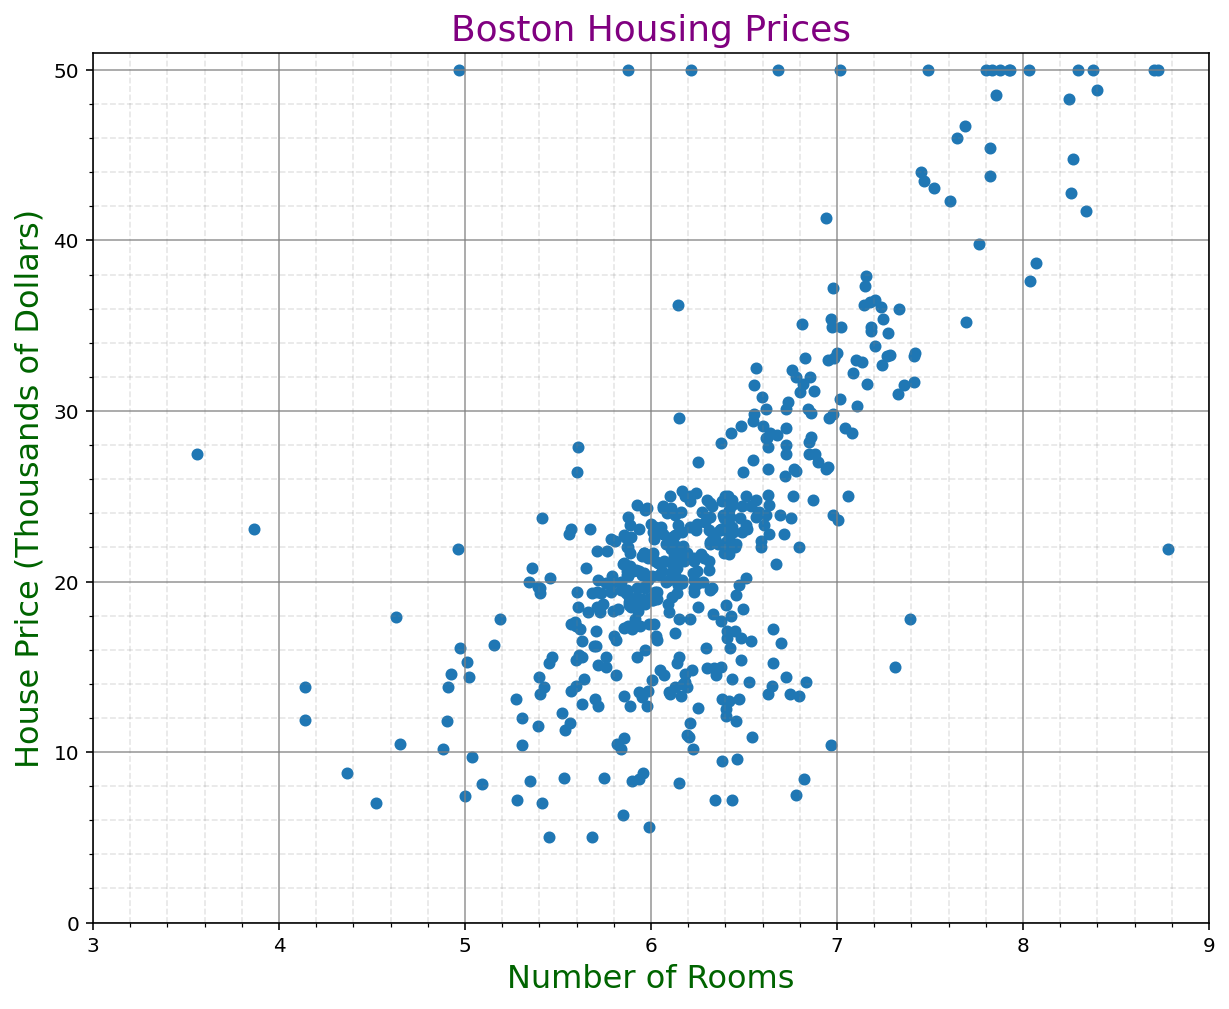

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=df['rooms'], y=df['cmedv'],s=25)
ax.set_xlabel('Number of Rooms',fontsize=16,color='darkgreen')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='darkgreen')
ax.set_title('Boston Housing Prices',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [8]:
X = np.array(df['rooms']).reshape(-1,1)
y = np.array(df['cmedv']).reshape(-1,1)
dat = np.concatenate([X,y.reshape(-1,1)], axis=1)

In [9]:
'''
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=2021)

y_train = y_train.reshape(len(y_train),) #?
y_test = y_test.reshape(len(y_test),)

dat_train = np.concatenate([X_train,y_train.reshape(-1,1)], axis=1)
dat_train = dat_train[np.argsort(dat_train[:, 0])]

dat_test = np.concatenate([X_test,y_test.reshape(-1,1)], axis=1)
dat_test = dat_test[np.argsort(dat_test[:, 0])]

#print(dat_train) #[[xtrain, ytrain]] sorted by xtrain
'''

In [10]:
'''
# Create a Neural Network model
model = Sequential()
model.add(Dense(32, activation="relu", input_dim=1))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=100, verbose=1, callbacks=[es])

# Calculate predictions
yhat_nn = model.predict(dat_test[:,0])
'''

C:\Users\mnelk\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/1000
3/3 [==============================] - 1s 170ms/step - loss: 617.2780 - val_loss: 545.6238
Epoch 2/1000
3/3 [==============================] - 0s 27ms/step - loss: 611.4130 - val_loss: 543.5334
Epoch 3/1000
3/3 [==============================] - 0s 20ms/step - loss: 608.9038 - val_loss: 540.7707
Epoch 4/1000
3/3 [==============================] - 0s 26ms/step - loss: 605.8417 - val_loss: 537.7655
Epoch 5/1000
3/3 [==============================] - 0s 28ms/step - loss: 602.5708 - val_loss: 534.4713
Epoch 6/1000
3/3 [==============================] - 0s 25ms/step - loss: 598.8931 - val_loss: 530.9604
Epoch 7/1000
3/3 [==============================] - 0s 26ms/step - loss: 595.0770 - val_loss: 527.2284
Epoch 8/1000
3/3 [==============================] - 0s 26ms/step - loss: 590.9361 - val_loss: 523.4037
Epoch 9/1000
3/3 [==============================] - 0s 29ms/step - loss: 586.7621 - val_loss: 519.4695
Epoch 10/1000
3/3 [==============================] - 0s 27ms/step - loss

## Here are the predictions we made for the test data:

In [32]:
model_nn = model

In [19]:
from sklearn.metrics import mean_absolute_error

yhat_nn = model.predict(dat_test[:,0])
mae_nn = mean_absolute_error(dat_test[:,1], yhat_nn)
print("MAE Neural Network = ${:,.2f}".format(1000*mae_nn))

MAE Neural Network = $3,825.24


In [25]:
#yhat_lr = model_lowess(dat_train,dat_test,Quartic,0.45)
yhat_lr = lw_reg(dat_train[:,0],dat_train[:,1],dat_test[:,0],kern=Quartic,tau=0.45, intercept=True)
mae_nn = mean_absolute_error(dat_test[:,1], yhat_lr)
print("MAE Kernel Weighted Regression = ${:,.2f}".format(1000*mae_nn))

MAE Kernel Weighted Regression = $3,799.25


In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

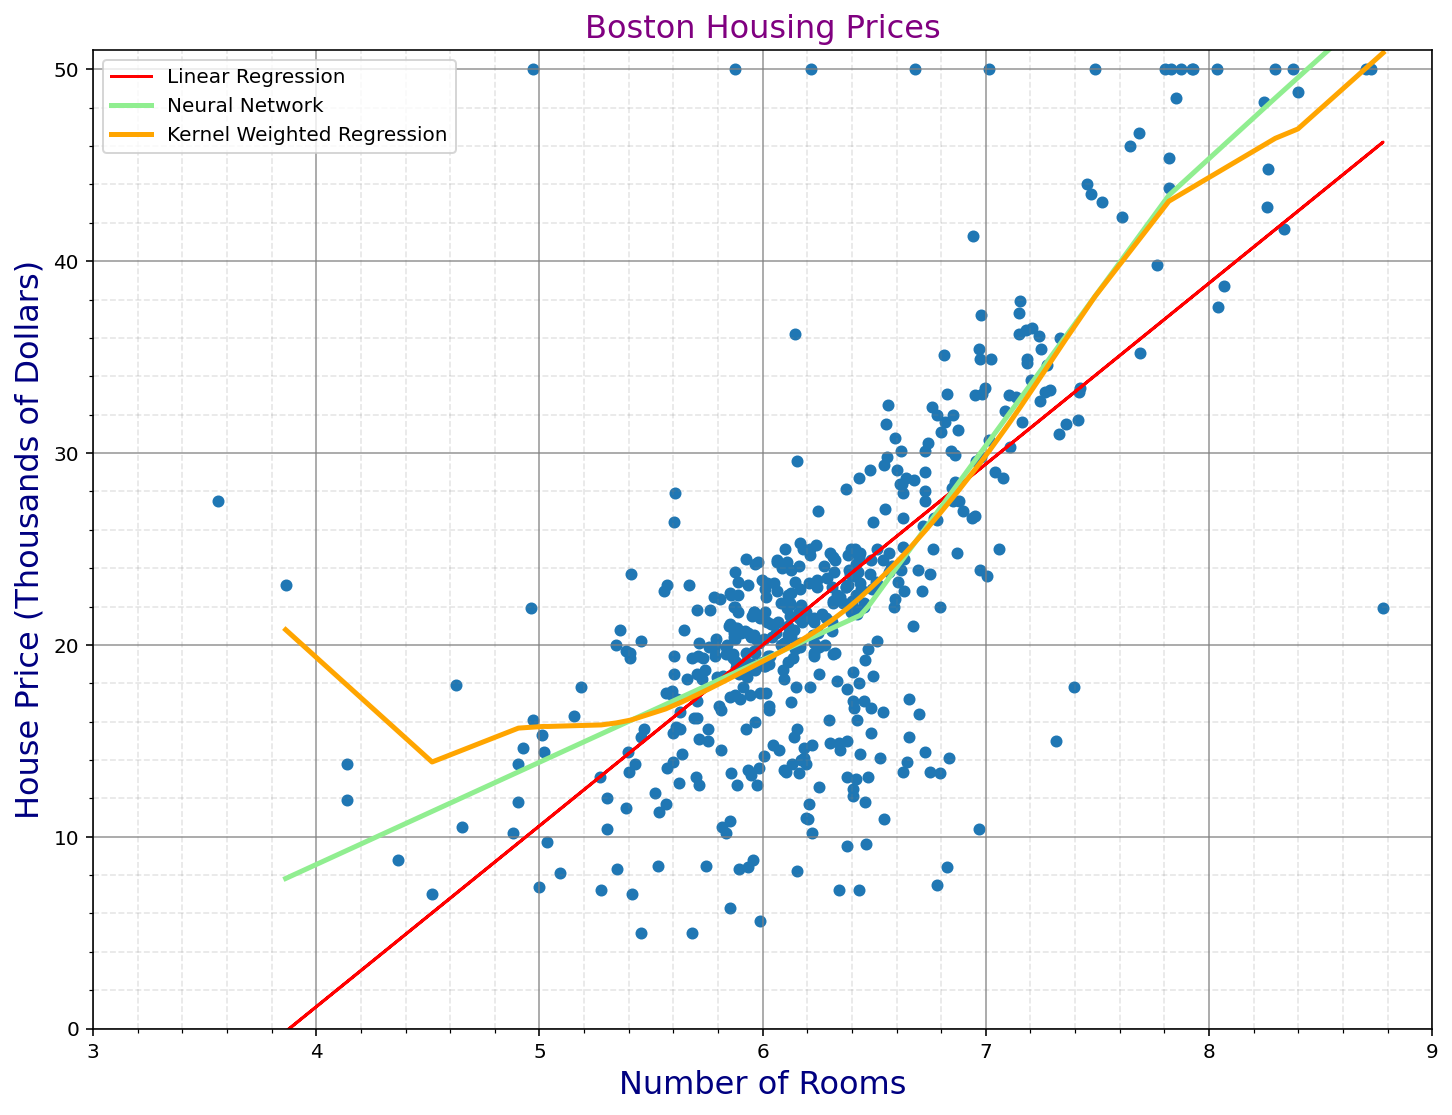

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=df['rooms'], y=df['cmedv'],s=25)
ax.plot(X_test, lm.predict(X_test), color='red',label='Linear Regression')
ax.plot(dat_test[:,0], yhat_nn, color='lightgreen',lw=2.5,label='Neural Network')
ax.plot(dat_test[:,0], model_lowess(dat_train,dat_test,Quartic,0.45), color='orange',lw=2.5,label='Locally Weighted Regression')
ax.set_xlabel('Number of Rooms',fontsize=16,color='navy')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='navy')
ax.set_title('Boston Housing Prices',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.legend()

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=1693)

In [ ]:
mae_lm = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0]
  y_train = dat[idxtrain,1]
  X_test  = dat[idxtest,0]
  y_test = dat[idxtest,1]
  lm.fit(X_train.reshape(-1,1),y_train)
  yhat_lm = lm.predict(X_test.reshape(-1,1))
  mae_lm.append(mean_absolute_error(y_test, yhat_lm))
print("Validated MAE Linear Regression = ${:,.2f}".format(1000*np.mean(mae_lm)))

Validated MAE Linear Regression = $4,444.47


In [ ]:
%%timeit -n 1

mae_lk = []

for idxtrain, idxtest in kf.split(dat):
  dat_test = dat[idxtest,:]
  y_test = dat_test[np.argsort(dat_test[:, 0]),1]
  yhat_lk = model_lowess(dat[idxtrain,:],dat[idxtest,:],Quartic,0.45)
  mae_lk.append(mean_absolute_error(y_test, yhat_lk))
print("Validated MAE Local Kernel Regression = ${:,.2f}".format(1000*np.mean(mae_lk)))

Validated MAE Local Kernel Regression = $4,111.28
Validated MAE Local Kernel Regression = $4,111.28
Validated MAE Local Kernel Regression = $4,111.28
1 loop, best of 3: 425 ms per loop


In [ ]:
%%timeit -n 1

mae_nn = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0]
  y_train = dat[idxtrain,1]
  X_test  = dat[idxtest,0]
  y_test = dat[idxtest,1]
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
  model.fit(X_train.reshape(-1,1),y_train,validation_split=0.3, epochs=1000, batch_size=100, verbose=0, callbacks=[es])
  yhat_nn = model.predict(X_test.reshape(-1,1))
  mae_nn.append(mean_absolute_error(y_test, yhat_nn))
print("Validated MAE Neural Network Regression = ${:,.2f}".format(1000*np.mean(mae_nn)))

Epoch 00227: early stopping
Epoch 00234: early stopping
Epoch 00365: early stopping
Epoch 00349: early stopping
Epoch 00262: early stopping
Epoch 00380: early stopping
Epoch 00487: early stopping
Epoch 00397: early stopping
Epoch 00366: early stopping
Epoch 00209: early stopping
Validated MAE Neural Network Regression = $4,118.47
Epoch 00300: early stopping
Epoch 00247: early stopping
Epoch 00357: early stopping
Epoch 00334: early stopping
Epoch 00524: early stopping
Epoch 00265: early stopping
Epoch 00541: early stopping
Epoch 00203: early stopping
Epoch 00224: early stopping
Epoch 00232: early stopping
Validated MAE Neural Network Regression = $4,129.09
Epoch 00240: early stopping
Epoch 00255: early stopping
Epoch 00262: early stopping
Epoch 00602: early stopping
Epoch 00305: early stopping
Epoch 00337: early stopping
Epoch 00250: early stopping
Epoch 00312: early stopping
Epoch 00350: early stopping
Epoch 00304: early stopping
Validated MAE Neural Network Regression = $4,144.78
1 lo

## XGBoost

https://towardsdatascience.com/xgboost-python-example-42777d01001e

In [ ]:
import xgboost as xgb

In [ ]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=3)

In [ ]:
%%timeit -n 1

mae_xgb = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0]
  y_train = dat[idxtrain,1]
  X_test  = dat[idxtest,0]
  y_test = dat[idxtest,1]
  model_xgb.fit(X_train.reshape(-1,1),y_train)
  yhat_xgb = model_xgb.predict(X_test.reshape(-1,1))
  mae_xgb.append(mean_absolute_error(y_test, yhat_xgb))
print("Validated MAE XGBoost Regression = ${:,.2f}".format(1000*np.mean(mae_xgb)))

Validated MAE XGBoost Regression = $4,141.61
Validated MAE XGBoost Regression = $4,141.61
Validated MAE XGBoost Regression = $4,141.61
1 loop, best of 3: 321 ms per loop
